# Gaussian experiment
All data is generated on the fly

In [1]:
import sys
sys.path.append('../python')

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

from machine_learning import *

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


# Setup

In [2]:
dim = 6
M = int(2**10)
parameters = np.random.normal(0, 1, (M,dim))

def functional(x):
    return np.sum(np.sin(4*np.sin(x)), 1)

samples = functional(parameters)

gaussian_network =  [12, 12, 10, 12, 10, 12, 10, 10, 10, 12, 12,1]

epochs = 500000



# Small test of data

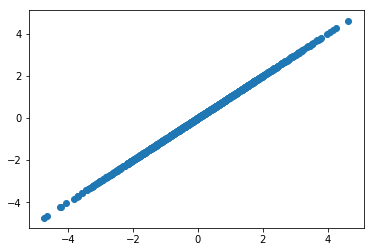

In [3]:
plt.scatter(samples, functional(parameters))

# Training


Training took 508.60663294792175 seconds


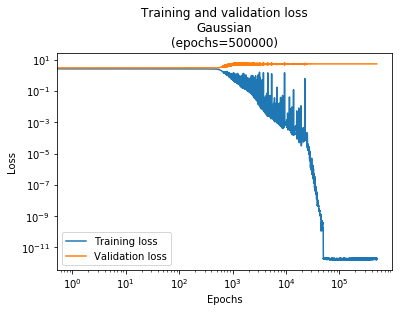


Training took 515.1732487678528 seconds


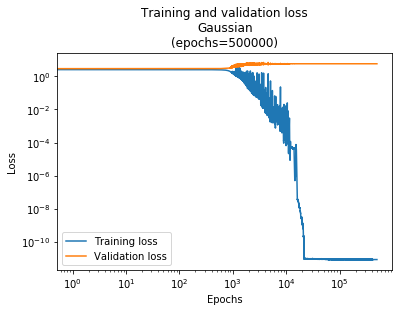


Training took 531.4252178668976 seconds


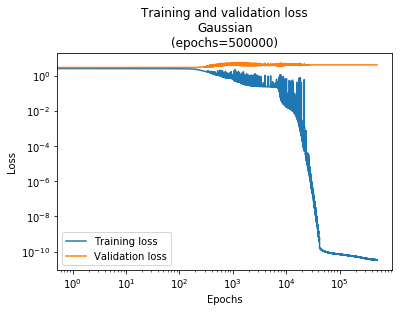


Training took 555.5496935844421 seconds


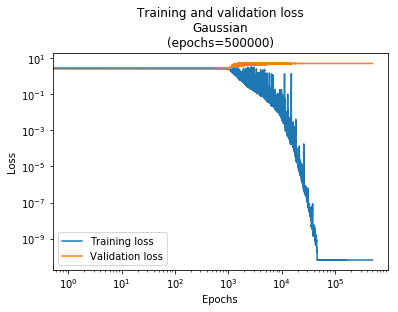


Training took 571.8776979446411 seconds


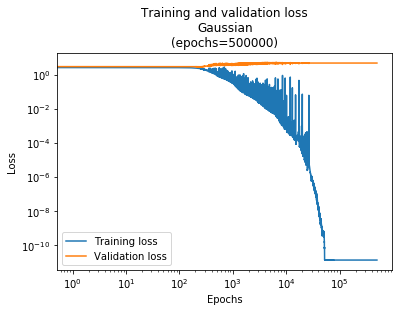

Best network index: 0
Total learning time took: 2689 s


#######################################################
#gaussian_SGD_mean_squared_error_ts_128_bs_128_network#
#######################################################
-----  ----  ----------
Layer  Size  Parameters
0      12    84
1      12    156
2      10    130
3      12    132
4      10    130
5      12    132
6      10    130
7      10    110
8      10    110
9      12    132
10     12    156
11     1     13
Sum          1415
-----  ----  ----------
#######################################################


Training took 573.2344472408295 seconds
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


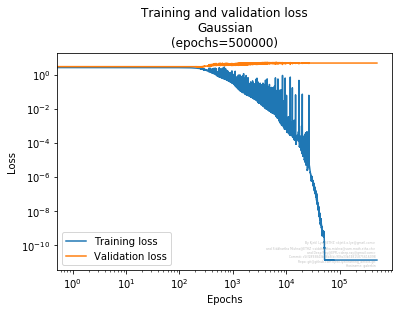

(1024,)
(1024, 1)
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


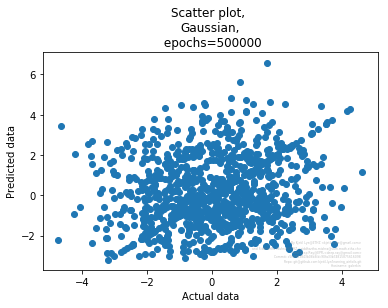

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                84        
_________________________________________________________________
dense_2 (Dense)              (None, 12)                156       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                130       
_________________________________________________________________
dense_4 (Dense)              (None, 12)                132       
_________________________________________________________________
dense_5 (Dense)              (None, 10)                130       
_________________________________________________________________
dense_6 (Dense)              (None, 12)                132       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                130       
__________

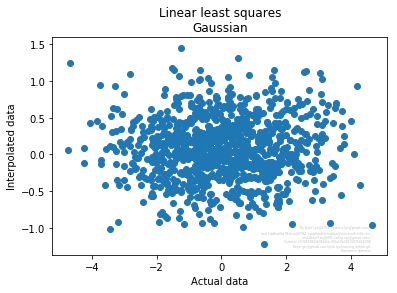

(1024,)
(1024, 6)
Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


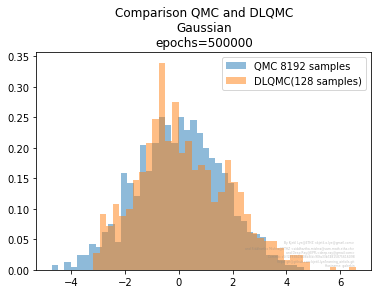

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


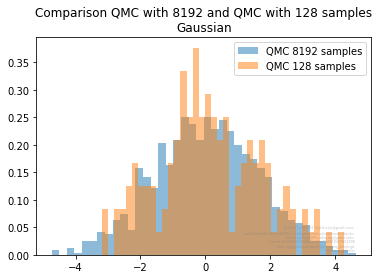

Horizontal alignment will be ignored as no 'x tick label text width' has been passed in the 'extra' parameter
Horizontal alignment will be ignored as no 'y tick label text width' has been passed in the 'extra' parameter


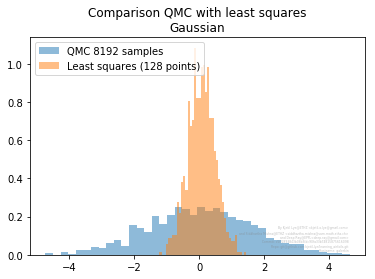

AttributeError: module 'numpy' has no attribute 'norm'

In [4]:

train_sizes = [ 128, 256, 512, 1024]

optimizers = {"SGD": keras.optimizers.SGD,
             "Adam": keras.optimizers.Adam}

losses = ["mean_squared_error", "mean_absolute_error"]

for optimizer in optimizers.keys():
    for loss in losses:
        display(HTML("<h1>{} with {}</h1>".format(optimizer, loss)))


        for train_size in train_sizes:
            batch_size = train_size
            validation_size=train_size
            tables = Tables.make_default()
            
            
            network_information = NetworkInformation(optimizer=optimizers[optimizer], epochs=epochs, 
                                                         network=gaussian_network, train_size=train_size,
                                                         validation_size=validation_size,
                                                        loss=loss)
                
            output_information = OutputInformation(tables=tables, title='Gaussian',
                                                      short_title='Gaussian')
            showAndSave.prefix='gaussian_%s_%s_ts_%d_bs_%d' %(optimizer, loss, batch_size, train_size)
            get_network_and_postprocess(parameters, samples, network_information = network_information,
                    output_information = output_information)
            
            showAndSave.prefix='gaussian_%s_%s_all_ts_%d_bs_%d' %(optimizer, loss, batch_size, train_size)
            tables.write_tables()
        
